In [15]:
import os
import pickle
import torch
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from abc import ABC, abstractmethod
from sklearn.neighbors import NearestNeighbors
from sentence_transformers import SentenceTransformer 
from sklearn.metrics.pairwise import cosine_similarity


In [16]:
class BaseRecommender(ABC):
    def __init__(self, name):
        self.name = name
        self.train_df = None
        
    @abstractmethod
    def fit(self, train_df):
        """Treina o modelo com os dados de treino."""
        pass
    
    @abstractmethod
    def recommend(self, author_id, top_n=10):
        """Retorna uma lista de author_ids recomendados."""
        pass

In [17]:
class TopologyRecommender(BaseRecommender):
    def __init__(self):
        super().__init__("Topology (Graph Coauthor)")
        self.graph = defaultdict(set)
        self.popular_authors = []
        
    def fit(self, train_df):
        self.train_df = train_df
        print(f"[{self.name}] Construindo grafo...")
        
        # Construção do Grafo
        for _, group in train_df.groupby('work_id'):
            authors = group['author_id'].tolist()
            if len(authors) > 1:
                for u, v in itertools.permutations(authors, 2):
                    self.graph[u].add(v)
        
        # Cálculo de Popularidade (para fallback)
        popularity_counter = Counter()
        for author, neighbors in self.graph.items():
            popularity_counter[author] = len(neighbors)
        self.popular_authors = [auth for auth, _ in popularity_counter.most_common()]
        print(f"[{self.name}] Grafo construído com {len(self.graph)} autores.")

    def recommend(self, author_id, top_n=10):
        recommendations = []
        current_coauthors = self.graph.get(author_id, set())
        
        # Lógica de Amigos em Comum (2 hops)
        if author_id in self.graph:
            candidates = []
            for neighbor in current_coauthors:
                neighbors_of_neighbor = self.graph.get(neighbor, set())
                for candidate in neighbors_of_neighbor:
                    if candidate != author_id and candidate not in current_coauthors:
                        candidates.append(candidate)
            
            recommendations = [c[0] for c in Counter(candidates).most_common(top_n)]
        
        # Fallback: Populares
        if len(recommendations) < top_n:
            for pop in self.popular_authors:
                if pop != author_id and pop not in recommendations and pop not in current_coauthors:
                    recommendations.append(pop)
                    if len(recommendations) >= top_n:
                        break
                        
        return recommendations[:top_n]


In [18]:
class IdealTopologyRecommender(BaseRecommender):
    def __init__(self, base_topology_model, ground_truth):
        super().__init__("Ideal Topology (Oracle)")
        self.base_model = base_topology_model
        self.ground_truth = ground_truth
        
    def fit(self, train_df):
        # Não precisamos treinar nada aqui, o modelo base já foi treinado.
        pass
        
    def recommend(self, author_id, top_n=10):
        # 1. Puxamos uma quantidade massiva de candidatos do modelo base.
        # Isso garante que pegaremos todos os "amigos de amigos" que a topologia encontrou.
        all_possible_candidates = self.base_model.recommend(author_id, top_n=5000)
        
        # 2. Consultamos o gabarito (quem o autor realmente conheceu no futuro)
        actual_future_coauthors = self.ground_truth.get(author_id, set())
        
        # 3. A "Trapaça" do Oráculo: Filtramos quem é acerto e forçamos para o topo da lista
        perfect_hits = [c for c in all_possible_candidates if c in actual_future_coauthors]
        the_rest = [c for c in all_possible_candidates if c not in actual_future_coauthors]
        
        # 4. Juntamos as listas. Os acertos (hits) virão primeiro.
        ideal_recommendation = perfect_hits + the_rest
        
        # Retornamos apenas a quantidade pedida pela função de avaliação
        return ideal_recommendation[:top_n]

In [19]:
def calculate_ndcg(recommended_list, relevant_set, k):
    """
    Calcula o NDCG@k (Normalized Discounted Cumulative Gain).
    
    Args:
        recommended_list: Lista de itens recomendados (ordenados)
        relevant_set: Conjunto de itens relevantes (ground truth)
        k: Número de itens a considerar (top-k)
    
    Returns:
        NDCG@k score (0.0 a 1.0)
    """
    if len(relevant_set) == 0:
        return 0.0
    
    # DCG: Discounted Cumulative Gain
    dcg = 0.0
    for i, item in enumerate(recommended_list[:k], 1):
        if item in relevant_set:
            dcg += 1.0 / np.log2(i + 1)
    
    # IDCG: Ideal DCG (ordenando os relevantes primeiro)
    idcg = 0.0
    num_relevant = min(len(relevant_set), k)
    for i in range(1, num_relevant + 1):
        idcg += 1.0 / np.log2(i + 1)
    
    # NDCG = DCG / IDCG
    if idcg == 0:
        return 0.0
    return dcg / idcg


def calculate_mrr_at_k(recommended_list, relevant_set, k):
    """
    Calcula o MRR@k (Mean Reciprocal Rank at k).
    
    O MRR@k só considera o primeiro item relevante se ele aparecer dentro das 
    primeiras k posições. Se o primeiro relevante aparecer após a posição k, 
    o MRR@k é 0.
    
    Args:
        recommended_list: Lista de itens recomendados (ordenados)
        relevant_set: Conjunto de itens relevantes (ground truth)
        k: Número máximo de posições a considerar (top-k)
    
    Returns:
        Reciprocal Rank@k (1/rank do primeiro relevante dentro de k, ou 0 se nenhum relevante)
    """
    if len(relevant_set) == 0:
        return 0.0
    
    # Considera apenas as primeiras k posições
    for rank, item in enumerate(recommended_list[:k], 1):
        if item in relevant_set:
            return 1.0 / rank
    
    return 0.0


def evaluate_models(models, test_ground_truth, train_graph_check, K_values=[5, 10]):
    results = {}
    
    # 1. Definir o maior K necessário para a avaliação
    max_k_eval = max(K_values)
    
    # 2. Definir um "Buffer" de busca. 
    # Pedimos 2x ou 3x mais itens para garantir que, após remover 
    # os coautores antigos, ainda sobrem itens suficientes para encher o max_k_eval.
    search_limit = max_k_eval * 3 
    
    for model in models:
        print(f"\nAvaliando modelo: {model.name}...")
        model_metrics = {k: {'precision': [], 'recall': [], 'ndcg': [], 'mrr': []} for k in K_values}
        
        for author_id, actual_new_coauthors in test_ground_truth.items():
            # SOLICITAÇÃO EXPANDIDA: Pede mais itens do que o necessário
            recs = model.recommend(author_id, top_n=search_limit)
            
            # FILTRAGEM: Remove coautores que já existem no treino
            past_coauthors = train_graph_check.get(author_id, set())
            valid_recs = [r for r in recs if r not in past_coauthors]
            
            # CORTE FINAL: Garante que a lista tenha no máximo o tamanho do maior K avaliado
            # Isso garante consistência: estamos avaliando as melhores "valid_recs" disponíveis
            valid_recs = valid_recs[:max_k_eval]
            
            for k in K_values:
                # O top_k aqui é seguro, pois valid_recs já está limpo
                top_k_recs = valid_recs[:k]
                
                hits = len(set(top_k_recs) & actual_new_coauthors)
                
                # Métricas padrão
                p = hits / k if k > 0 else 0
                r = hits / len(actual_new_coauthors) if len(actual_new_coauthors) > 0 else 0
                ndcg = calculate_ndcg(top_k_recs, actual_new_coauthors, k)
                mrr = calculate_mrr_at_k(valid_recs, actual_new_coauthors, k) # MRR usa a lista até K implícito
                
                model_metrics[k]['precision'].append(p)
                model_metrics[k]['recall'].append(r)
                model_metrics[k]['ndcg'].append(ndcg)
                model_metrics[k]['mrr'].append(mrr)
        
        # Consolidação dos resultados (Média)
        results[model.name] = {}
        for k in K_values:
            avg_p = np.mean(model_metrics[k]['precision'])
            avg_r = np.mean(model_metrics[k]['recall'])
            avg_ndcg = np.mean(model_metrics[k]['ndcg'])
            avg_mrr = np.mean(model_metrics[k]['mrr'])
            f1 = 2 * (avg_p * avg_r) / (avg_p + avg_r) if (avg_p + avg_r) > 0 else 0
            
            results[model.name][k] = {'P': avg_p, 'R': avg_r, 'F1': f1, 'NDCG': avg_ndcg, 'MRR': avg_mrr}
            print(f"  K={k}: Precision={avg_p:.4f}, Recall={avg_r:.4f}, F1={f1:.4f}, NDCG={avg_ndcg:.4f}, MRR@k={avg_mrr:.4f}")
            
    return results

In [20]:
def plot_model_comparison(results, figsize=(25, 5)):
    model_names = list(results.keys())
    k_values = sorted([k for k in results[model_names[0]].keys() if isinstance(k, int)])
    
    # Preparar dados para cada métrica
    metrics_data = {
        'Precision': {model: [results[model][k]['P'] for k in k_values] for model in model_names},
        'Recall': {model: [results[model][k]['R'] for k in k_values] for model in model_names},
        'F1-Score': {model: [results[model][k]['F1'] for k in k_values] for model in model_names},
        'NDCG': {model: [results[model][k]['NDCG'] for k in k_values] for model in model_names},
        'MRR@k': {model: [results[model][k]['MRR'] for k in k_values] for model in model_names}
    }
    
    # Criar figura com 5 subplots para métricas dependentes de K
    fig, axes = plt.subplots(1, 5, figsize=figsize)
    fig.suptitle('Comparação de Modelos de Link Prediction', fontsize=16, fontweight='bold')
    
    # Cores e estilos para cada modelo
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    markers = ['o', 's', '^', 'D', 'v']
    
    # Plotar cada métrica dependente de K
    for idx, (metric_name, data) in enumerate(metrics_data.items()):
        ax = axes[idx]
        
        for i, model in enumerate(model_names):
            ax.plot(
                k_values, 
                data[model], 
                marker=markers[i % len(markers)],
                label=model,
                color=colors[i % len(colors)],
                linewidth=2,
                markersize=8
            )
        
        ax.set_xlabel('K (Top-K)', fontsize=11)
        ax.set_ylabel(metric_name, fontsize=11)
        ax.set_title(f'{metric_name} por K', fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.legend(fontsize=9)
        ax.set_xticks(k_values)
        
    plt.tight_layout()
    plt.show()
    
    return fig

In [21]:
database_path = 'database_50k'
authors_df = pd.read_csv(f'{database_path}/authorships.csv')
works_df = pd.read_csv(f'{database_path}/works.csv')

merged_df = authors_df.merge(
    works_df[['id', 'publication_date', 'title', 'abstract', 'language']], 
    left_on='work_id', right_on='id'
)
merged_df['publication_date'] = pd.to_datetime(merged_df['publication_date'], errors='coerce')
merged_df = merged_df.dropna(subset=['publication_date', 'author_id', 'title', 'abstract', 'language']).drop(columns=['id'])
merged_df = merged_df[merged_df['language'] == 'en']

unique_works = merged_df[['work_id', 'publication_date']].drop_duplicates().sort_values('publication_date')
split_idx = int(len(unique_works) * 0.8)

train_work_ids = set(unique_works.iloc[:split_idx]['work_id'])
test_work_ids = set(unique_works.iloc[split_idx:]['work_id'])

train_df = merged_df[merged_df['work_id'].isin(train_work_ids)]
test_df = merged_df[merged_df['work_id'].isin(test_work_ids)]

def build_graph(df):
    graph = defaultdict(set)
    for _, group in df.groupby('work_id'):
        authors = group['author_id'].tolist()
        
        if len(authors) > 1:
            for u, v in itertools.permutations(authors, 2):
                graph[u].add(v)

    return graph

train_graph = build_graph(train_df)
test_graph_raw = build_graph(test_df)

test_ground_truth = defaultdict(set)

for author, coauthors in test_graph_raw.items():
    # Pega quem o autor colaborou no futuro
    future_coauthors = coauthors
    
    # Remove quem ele já conhecia no passado (não é predição nova)
    past_coauthors = train_graph.get(author, set())
    new_links = future_coauthors - past_coauthors
    
    if new_links:
        test_ground_truth[author] = new_links

C:\Users\BSBCo\AppData\Local\Temp\ipykernel_24692\1540647326.py:3: DtypeWarning: Columns (0: is_retracted) have mixed types. Specify dtype option on import or set low_memory=False.
  works_df = pd.read_csv(f'{database_path}/works.csv')


In [22]:
topo_model = TopologyRecommender()
ideal_topo_model = IdealTopologyRecommender(topo_model, test_ground_truth)

models = [
    topo_model,
    ideal_topo_model
]

for model in models:
    model.fit(train_df) 
    
metrics = evaluate_models(models, test_ground_truth, train_graph, K_values=[5, 10, 20, 50, 100, 200])
# plot_model_comparison(metrics)

[Topology (Graph Coauthor)] Construindo grafo...
[Topology (Graph Coauthor)] Grafo construído com 25260 autores.

Avaliando modelo: Topology (Graph Coauthor)...
  K=5: Precision=0.0169, Recall=0.0127, F1=0.0145, NDCG=0.0200, MRR@k=0.0386
  K=10: Precision=0.0156, Recall=0.0221, F1=0.0183, NDCG=0.0225, MRR@k=0.0452
  K=20: Precision=0.0158, Recall=0.0437, F1=0.0232, NDCG=0.0303, MRR@k=0.0540
  K=50: Precision=0.0111, Recall=0.0704, F1=0.0192, NDCG=0.0388, MRR@k=0.0594
  K=100: Precision=0.0071, Recall=0.0938, F1=0.0131, NDCG=0.0446, MRR@k=0.0607
  K=200: Precision=0.0044, Recall=0.1172, F1=0.0084, NDCG=0.0503, MRR@k=0.0615

Avaliando modelo: Ideal Topology (Oracle)...
  K=5: Precision=0.3372, Recall=0.2193, F1=0.2657, NDCG=0.4902, MRR@k=0.9065
  K=10: Precision=0.1886, Recall=0.2245, F1=0.2050, NDCG=0.4053, MRR@k=0.9065
  K=20: Precision=0.1024, Recall=0.2270, F1=0.1411, NDCG=0.3677, MRR@k=0.9065
  K=50: Precision=0.0449, Recall=0.2291, F1=0.0751, NDCG=0.3485, MRR@k=0.9065
  K=100: Prec

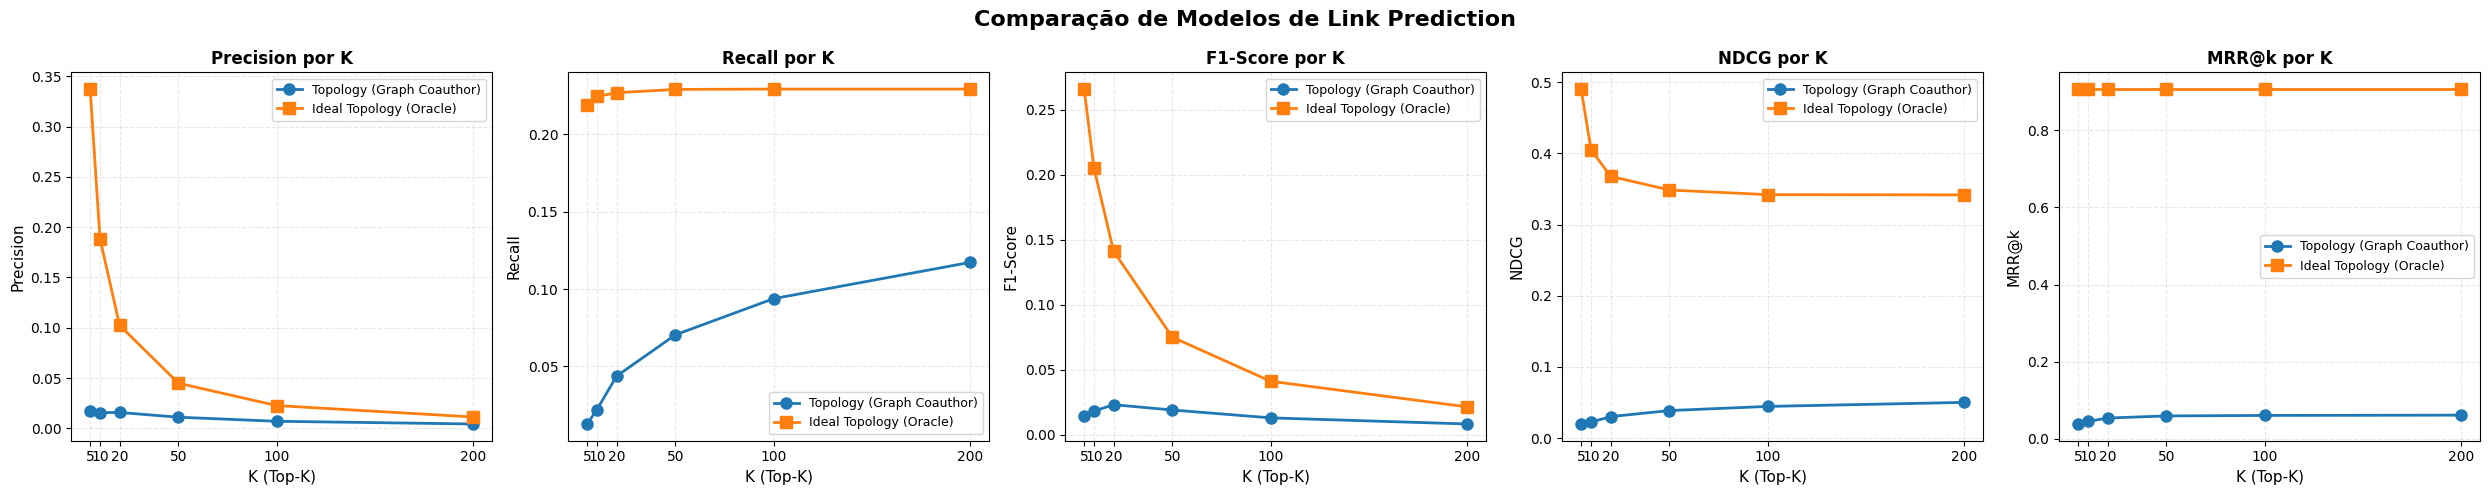

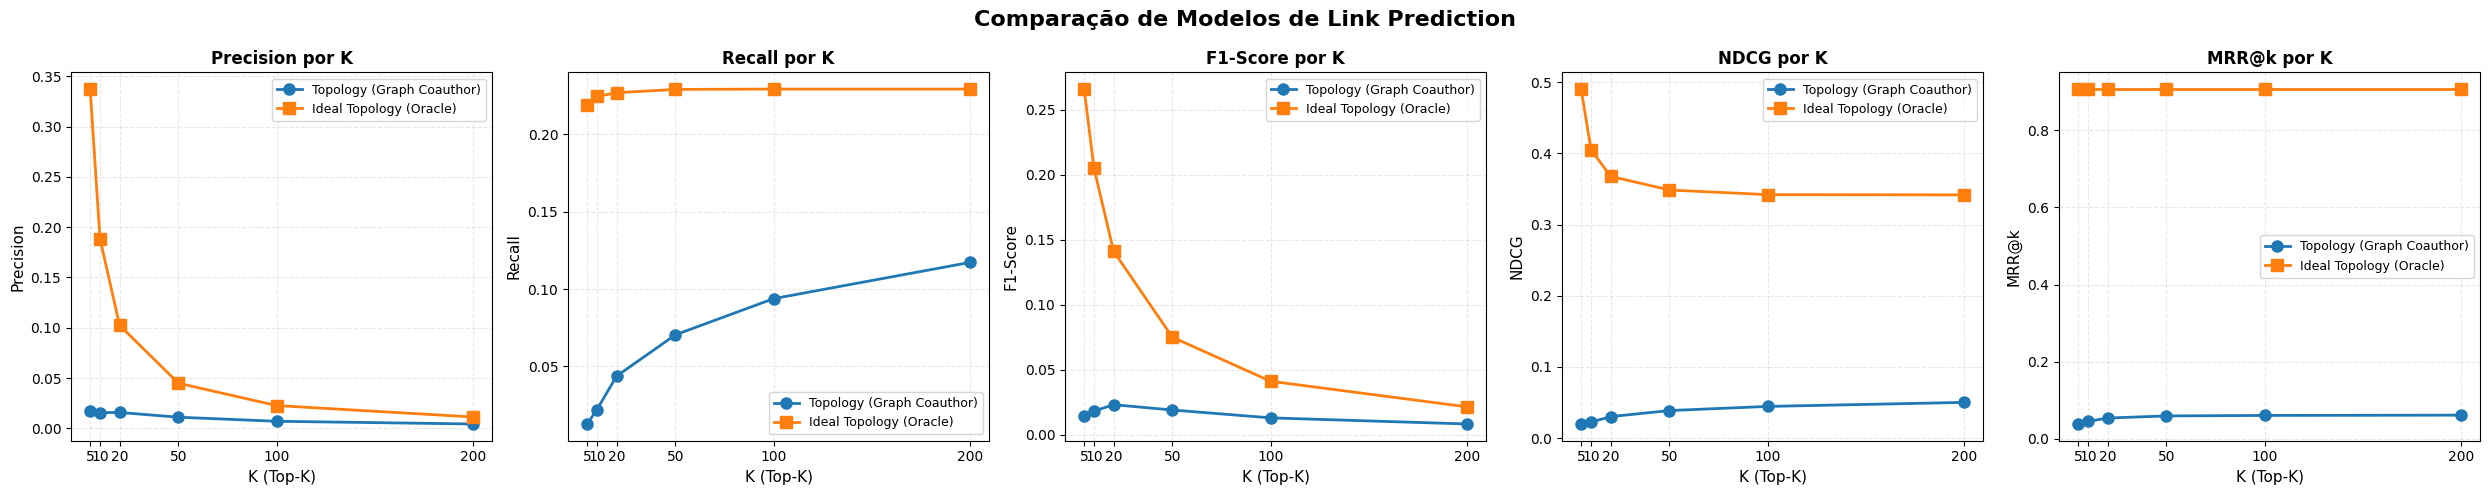

In [23]:
plot_model_comparison(metrics)